In [1]:
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "retina"

In [2]:
import addict
import copy
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.tri as tri
from importlib import reload

import celeri

plt.rcParams["text.usetex"] = (
    False  # Plotting is much much faster with tex fonts turned off
)

# Read data, calculate elastic TDE to station partials and distance weighted smoothing matrix

In [3]:
# command_file_name = "../data/western_north_america/basic_command.json"
COMMAND_FILE_NAME = "../data/command/western_north_america_command.json"
# command, segment, block, meshes, station, mogi, sar = celeri.read_data(
#     command_file_name
# )

command = celeri.get_command(COMMAND_FILE_NAME)
segment, block, meshes, station, mogi, sar = celeri.read_data(command)

station = celeri.process_station(station, command)
operators = addict.Dict()
# operators.tri_station = celeri.get_tri_station_operator_okada(meshes, station, command)
operators.tri_station = celeri.get_tde_to_velocities(meshes, station, command)
celeri.get_all_mesh_smoothing_matrices(meshes, operators)

# Eliminate matrix entries for vertical displacments and tensile slip
tde_matrix = copy.deepcopy(operators.tri_station)
tde_matrix = np.delete(tde_matrix, np.arange(2, tde_matrix.shape[0], 3), axis=0)
tde_matrix = np.delete(tde_matrix, np.arange(2, tde_matrix.shape[1], 3), axis=1)

2024-06-04 14:01:29.945 | INFO     | celeri.celeri:read_data:135 - Reading data files


2024-06-04 14:01:29.950 | SUCCESS  | celeri.celeri:read_data:139 - Read: ../data/segment/western_north_america_segment.csv
2024-06-04 14:01:29.952 | SUCCESS  | celeri.celeri:read_data:144 - Read: ../data/block/western_north_america_block.csv
2024-06-04 14:01:29.952 | SUCCESS  | celeri.celeri:read_data:151 - Read: ../data/mesh/western_north_america_mesh_parameters.json


Warning: The file contains tag data that couldn't be processed.

2024-06-04 14:01:30.004 | SUCCESS  | celeri.celeri:read_data:272 - Read: ../data/mesh/cascadia.msh
2024-06-04 14:01:30.007 | SUCCESS  | celeri.celeri:read_data:308 - Read: ../data/station/western_north_america_station.csv
2024-06-04 14:01:30.008 | INFO     | celeri.celeri:read_data:323 - No mogi_file_name
2024-06-04 14:01:30.009 | INFO     | celeri.celeri:read_data:345 - No sar_file_name
Calculating cutde partials for triangles: 100%|██████████| 1841/1841 [00:10<00:00, 173.58it/s]


# Functions used throughout.  Some may eventually go celeri.py

In [4]:
def plot_slip_distributions(
    mesh, slip_distribution_input, slip_distribution_estimated, suptitle_string
):
    triangulation = tri.Triangulation(mesh.centroids[:, 0], mesh.centroids[:, 1])

    levels = np.linspace(-1.0, 1.0, 30)
    vmin = -1.0
    vmax = 1.0
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 4, 1)
    plt.title("input strike-slip")
    tcf = plt.tricontourf(
        triangulation,
        slip_distribution_input[0::2],
        cmap="seismic",
        levels=levels,
        vmin=vmin,
        vmax=vmax,
        extend="both",
    )
    plt.tricontour(
        triangulation,
        slip_distribution_input[0::2],
        colors="k",
        linewidths=0.25,
        levels=levels,
    )
    plt.plot(meshes[0].x_perimeter, meshes[0].y_perimeter, color="black", linewidth=1)
    plt.colorbar(tcf)
    plt.gca().set_aspect("equal", adjustable="box")
    plt.xlim([230.0, 240.0])
    plt.ylim([37.5, 52.5])
    plt.xticks([])
    plt.yticks([])

    plt.subplot(1, 4, 2)
    plt.title("estimated strike-slip")
    tcf = plt.tricontourf(
        triangulation,
        slip_distribution_estimated[0::2],
        cmap="seismic",
        levels=levels,
        vmin=vmin,
        vmax=vmax,
        extend="both",
    )
    plt.tricontour(
        triangulation,
        slip_distribution_estimated[0::2],
        colors="k",
        linewidths=0.25,
        levels=levels,
    )
    plt.plot(meshes[0].x_perimeter, meshes[0].y_perimeter, color="black", linewidth=1)
    plt.colorbar(tcf)
    plt.gca().set_aspect("equal", adjustable="box")
    plt.xlim([230.0, 240.0])
    plt.ylim([37.5, 52.5])
    plt.xticks([])
    plt.yticks([])

    plt.subplot(1, 4, 3)
    plt.title("input dip-slip")
    tcf = plt.tricontourf(
        triangulation,
        slip_distribution_input[1::2],
        cmap="seismic",
        levels=levels,
        vmin=vmin,
        vmax=vmax,
        extend="both",
    )
    plt.tricontour(
        triangulation,
        slip_distribution_input[1::2],
        colors="k",
        linewidths=0.25,
        levels=levels,
    )
    plt.plot(meshes[0].x_perimeter, meshes[0].y_perimeter, color="black", linewidth=1)
    plt.colorbar(tcf)
    plt.gca().set_aspect("equal", adjustable="box")
    plt.xlim([230.0, 240.0])
    plt.ylim([37.5, 52.5])
    plt.xticks([])
    plt.yticks([])

    plt.subplot(1, 4, 4)
    plt.title("estimated dip-slip")
    tcf = plt.tricontourf(
        triangulation,
        slip_distribution_estimated[1::2],
        cmap="seismic",
        levels=levels,
        vmin=vmin,
        vmax=vmax,
        extend="both",
    )
    plt.tricontour(
        triangulation,
        slip_distribution_estimated[1::2],
        colors="k",
        linewidths=0.25,
        levels=levels,
    )
    plt.plot(meshes[0].x_perimeter, meshes[0].y_perimeter, color="black", linewidth=1)
    plt.colorbar(tcf)
    plt.gca().set_aspect("equal", adjustable="box")
    plt.xlim([230.0, 240.0])
    plt.ylim([37.5, 52.5])
    plt.xticks([])
    plt.yticks([])

    plt.suptitle(suptitle_string)
    plt.show()


def get_synthetic_displacements(mesh, tri_linear_operator):
    """
    Prescribe dip-slip in a Gaussian pattern.
    """
    tri_centroid_to_mesh_lon = mesh.centroids[:, 0] - np.mean(mesh.centroids[:, 0])
    tri_centroid_to_mesh_lat = mesh.centroids[:, 1] - np.mean(mesh.centroids[:, 1])

    # Hardcoded northern Cascadia example that Jack suggested.
    tri_centroid_to_mesh_lon = mesh.centroids[:, 0] - 234.5
    tri_centroid_to_mesh_lat = mesh.centroids[:, 1] - 48.5

    # Southern Cascadia example
    tri_centroid_to_mesh_lon = mesh.centroids[:, 0] - np.mean(mesh.centroids[:, 0]) - 2
    tri_centroid_to_mesh_lat = mesh.centroids[:, 1] - np.mean(mesh.centroids[:, 1])

    tri_centroid_to_mesh_centroid_distance = np.sqrt(
        tri_centroid_to_mesh_lon**2 + tri_centroid_to_mesh_lat**2
    )
    dip_slip_distribution = np.exp(
        -((tri_centroid_to_mesh_centroid_distance / 1.0) ** 2.0)
    )
    slip_distribution = np.zeros(2 * dip_slip_distribution.size)
    slip_distribution[1::2] = dip_slip_distribution  # Dip slip only
    slip_distribution[0::2] = 1e-4 * np.random.randn(
        dip_slip_distribution.size
    )  # Adding a teeny amount of non-zero noise here just so contouring works...ugh
    synthetic_displacements = tri_linear_operator @ slip_distribution
    return slip_distribution, synthetic_displacements


# Generate Guassian slip source and synthetic displacements
slip_distribution, synthetic_displacements = get_synthetic_displacements(
    meshes[0], tde_matrix
)
slip_distribution_strike_slip_true = slip_distribution[0::2]
slip_distribution_dip_slip_true = slip_distribution[1::2]

# Slip estimation with direct inverse and smoothing

/var/folders/pq/qqjshcd51vg5t9w5ws8wkmw00000gn/T/ipykernel_6999/709108058.py:22: UserWarning: No contour levels were found within the data range.
  plt.tricontour(
/var/folders/pq/qqjshcd51vg5t9w5ws8wkmw00000gn/T/ipykernel_6999/709108058.py:48: UserWarning: No contour levels were found within the data range.
  plt.tricontour(


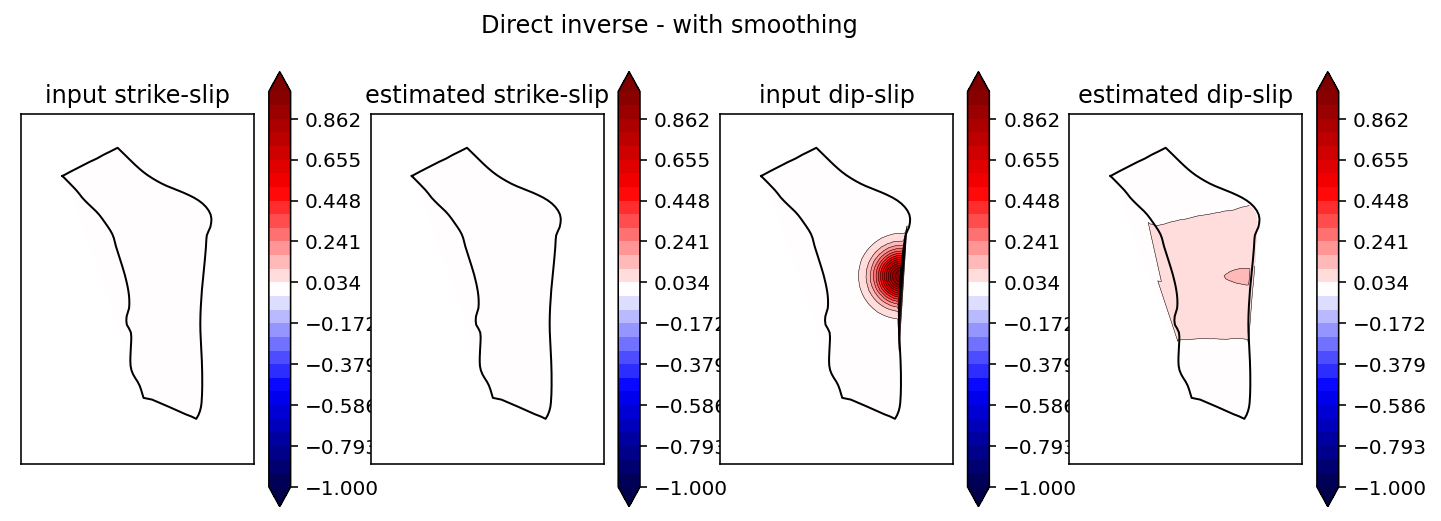

Dip-slip residual = 106.93839117397393


In [5]:
# Slip estimation with direct inverse and smoothing matrix
smoothing_matrix = operators.smoothing_matrix[0].toarray()
smoothing_matrix = np.delete(
    smoothing_matrix, np.arange(2, smoothing_matrix.shape[0], 3), axis=0
)
smoothing_matrix = np.delete(
    smoothing_matrix, np.arange(2, smoothing_matrix.shape[1], 3), axis=1
)
smoothing_matrix = (
    meshes[0].smoothing_weight * 1e-8 * smoothing_matrix
)  # Weight smoothing matrix
tde_and_smoothing_matrix = np.vstack((tde_matrix, smoothing_matrix))
synthetic_displacements_with_smoothing = np.hstack(
    (synthetic_displacements, np.zeros(smoothing_matrix.shape[0]).T)
)
slip_distribution_estimated = (
    np.linalg.inv(tde_and_smoothing_matrix.T @ tde_and_smoothing_matrix)
    @ tde_and_smoothing_matrix.T
    @ synthetic_displacements_with_smoothing
)
plot_slip_distributions(
    meshes[0],
    slip_distribution,
    slip_distribution_estimated,
    suptitle_string="Direct inverse - with smoothing",
)
print(
    "Dip-slip residual = "
    + str(
        np.sum(
            np.abs(slip_distribution_dip_slip_true - slip_distribution_estimated[1::2])
        )
    )
)